<a href="https://colab.research.google.com/github/Tabs2206/Meteor-Detection/blob/main/u-netmodel/ModelWithPolygonData_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow numpy pillow scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import json
import numpy as np
from PIL import Image
import base64
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io

# Define the target size for the images and masks
target_size = (128, 128)

def load_and_preprocess_image(image_path, mask_path):
    # Convert tensor paths to strings
    image_path = image_path.numpy().decode('utf-8')
    mask_path = mask_path.numpy().decode('utf-8')

    # Load the image
    image = Image.open(image_path).convert('RGB')
    print(f"Original Image Shape: {image.size}")
    # Resize the image
    image = image.resize(target_size)
    # Normalize the image to [0, 1]
    image_array = np.array(image) / 255.0
    print(f"Preprocessed Image Shape: {image_array.shape}")

    # Load the mask from JSON
    try:
        with open(mask_path, 'r') as f:
            mask_data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error reading JSON file {mask_path}: {e}")
        return None, None
    except FileNotFoundError as e:
        print(f"File not found: {mask_path}")
        return None, None

    # Decode the Base64 string to an image
    encoded_mask_data = mask_data.get('imageData', '')
    if not encoded_mask_data:
        print(f"Missing or invalid image data in {mask_path}")
        return None, None

    try:
        decoded_mask_data = base64.b64decode(encoded_mask_data)
    except base64.binascii.Error as e:
        print(f"Error decoding base64 data in {mask_path}: {e}")
        return None, None

    # Create an image from the decoded data
    try:
        mask_image = Image.open(io.BytesIO(decoded_mask_data))
    except Exception as e:
        print(f"Error creating image from data in {mask_path}: {e}")
        return None, None

    print(f"Original Mask Shape: {mask_image.size}")
    # Convert the mask image to grayscale (binary mask)
    mask_image = mask_image.convert('L')
    # Resize the mask
    mask_image = mask_image.resize(target_size)
    # Convert mask to a binary numpy array
    mask_array = np.array(mask_image) / 255.0
    mask_array = (mask_array > 0.5).astype(np.float32)  # Ensure binary mask
    mask_array = np.expand_dims(mask_array, axis=-1)  # Add channel dimension
    print(f"Preprocessed Mask Shape: {mask_array.shape}")

    return image_array, mask_array

# Prepare lists of image and mask paths for training
images_train_dir = '/content/drive/MyDrive/multi_class_json/images/train'
labels_train_dir = '/content/drive/MyDrive/multi_class_json/labels/train'

train_image_paths = [os.path.join(images_train_dir, fname) for fname in os.listdir(images_train_dir)]
train_mask_paths = [os.path.join(labels_train_dir, fname) for fname in os.listdir(labels_train_dir)]

# Split data into train and validation sets (80% train, 20% val)
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42
)

# Create TensorFlow Dataset objects for training and validation
def data_generator(image_paths, mask_paths, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.shuffle(buffer_size=len(image_paths))

    def load_image_and_mask(image_path, mask_path):
        image, mask = tf.py_function(load_and_preprocess_image, [image_path, mask_path], [tf.float32, tf.float32])
        image.set_shape([target_size[0], target_size[1], 3])
        mask.set_shape([target_size[0], target_size[1], 1])  # Set shape with channel
        return image, mask

    # Filter out invalid images and masks
    def is_valid_pair(image, mask):
        return tf.logical_and(tf.not_equal(tf.reduce_sum(image), 0), tf.not_equal(tf.reduce_sum(mask), 0))

    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.filter(is_valid_pair)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

# Create training and validation datasets
train_dataset = data_generator(train_image_paths, train_mask_paths)
val_dataset = data_generator(val_image_paths, val_mask_paths)


In [4]:
import tensorflow as tf

def unet(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate and compile the model
model = unet(input_shape=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [5]:
# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=100)

Epoch 1/100
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Original Mask Sha

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Streaming output truncated to the last 5000 lines.
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)Original Mask Shape: (860, 538)

Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)Original Mask Shape: (860, 538)

Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9942 - loss: 0.0239 - val_accuracy: 0.9943 - val_loss: 0.0295
Epoch 54/100
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)Original Image Sh

To Test the model over unseen data.

In [6]:
def preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    # Resize the image
    image = image.resize(target_size)
    # Normalize the image to [0, 1]
    image_array = np.array(image) / 255.0
    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    return image_array


In [8]:
def predict_mask(model, image_array):
    # Predict the mask
    prediction = model.predict(image_array)
    # Threshold the prediction to create a binary mask
    binary_mask = (prediction[0, :, :, 0] > 0.5).astype(np.uint8)
    return binary_mask


In [12]:
import matplotlib.pyplot as plt

def visualize_prediction(image_path, binary_mask):
    # Load the original image
    original_image = Image.open(image_path).convert('RGB')

    # Plot original image and mask
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(binary_mask, cmap='gray')
    plt.axis('off')
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


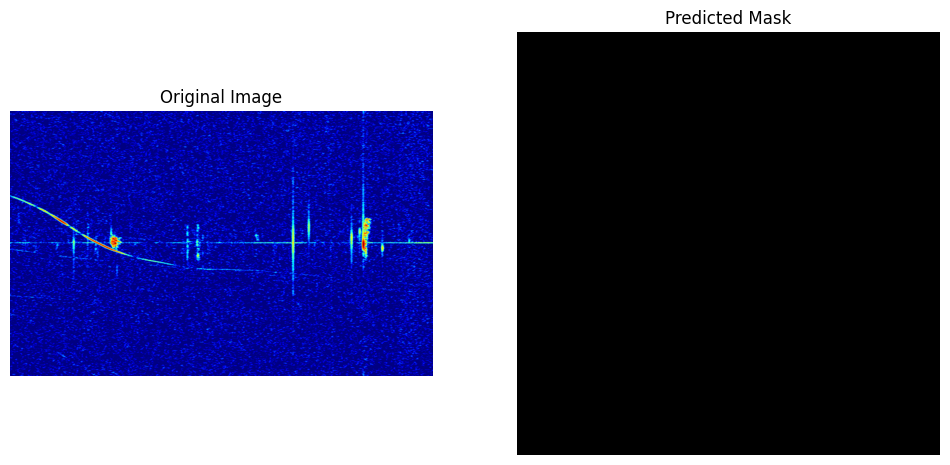

In [13]:
# Path to the unseen image
unseen_image_path = '/content/drive/MyDrive/multi_class_json/images/train/RAD_BEDOUR_20240619_0200_BEMAAM_SYS001.png'

# Preprocess the image
image_array = preprocess_image(unseen_image_path)

# Predict the mask
binary_mask = predict_mask(model, image_array)

# Visualize the prediction
visualize_prediction(unseen_image_path, binary_mask)


In [14]:
from tensorflow.keras import backend as K

def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    iou = intersection / union
    return iou

# Add IoU as a metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_metric])

# Re-evaluate to include IoU
loss, accuracy, iou = model.evaluate(val_dataset)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')
print(f'Validation IoU: {iou}')


Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)Preprocessed Image Shape: (128, 128, 3)

Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9943 - iou_metric: 0.0000e+00 - loss: 0.0321
Validation Loss: 0.03210898116230965
Vali

Original Image Shape: (860, 538)
Original Image Shape: (860, 538)Original Image Shape: (860, 538)

Preprocessed Image Shape: (128, 128, 3)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)

Preprocessed Image Shape: (128, 128, 3)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


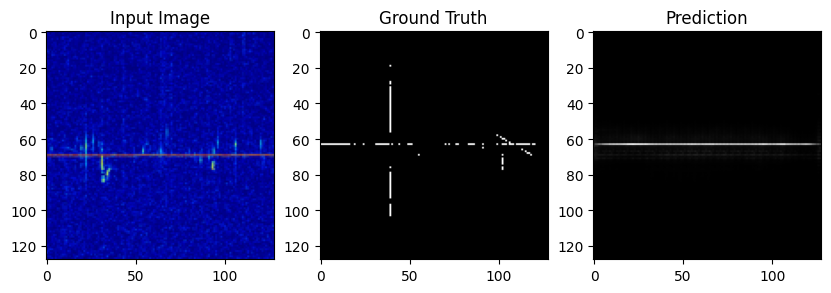

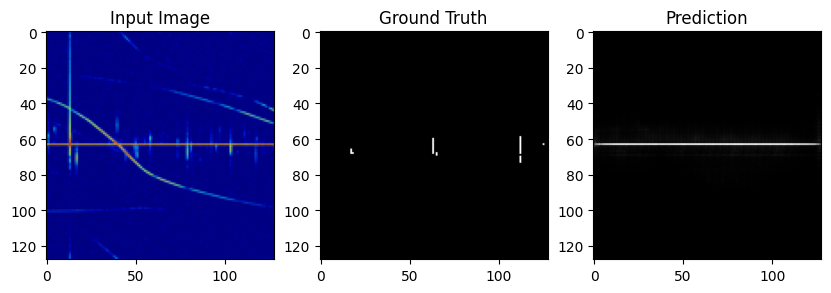

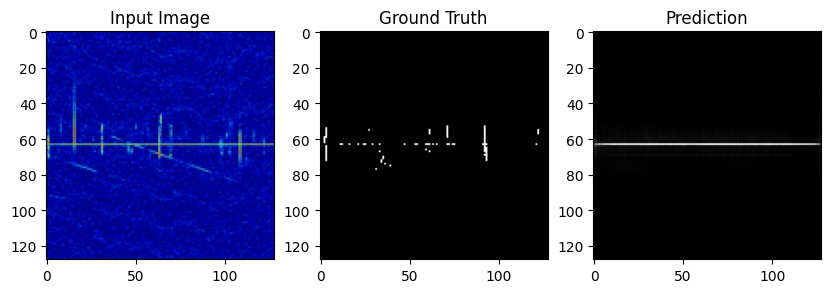

In [16]:
import matplotlib.pyplot as plt

# Get a batch of validation data
for images, masks in val_dataset.take(1):
    predictions = model.predict(images)

    for i in range(3):  # Show first 3 predictions
        plt.figure(figsize=(10, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title("Input Image")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title("Prediction")

        plt.show()



Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)

Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)Preprocessed Image Shape: (128, 128, 3)

Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


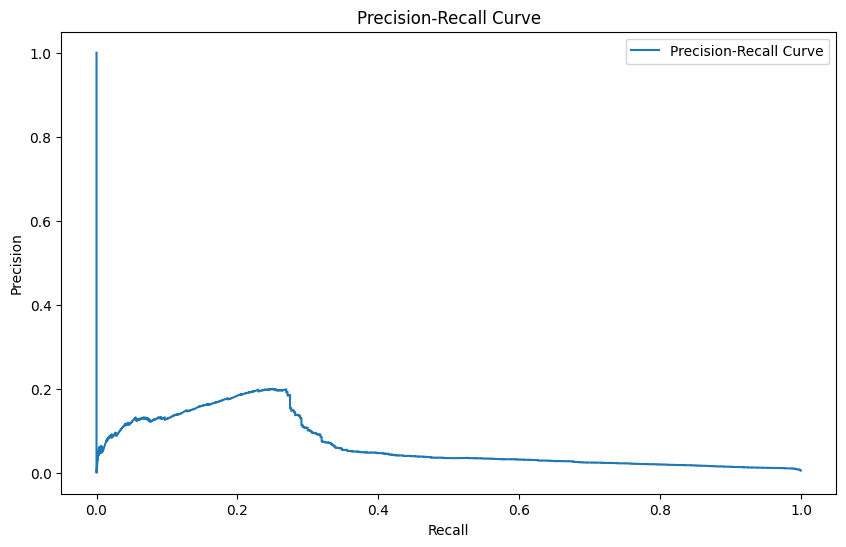

In [18]:
from sklearn.metrics import precision_recall_curve

y_true = []  # Ground truth masks
y_pred = []  # Predicted masks

# Collect all validation data and predictions
for images, masks in val_dataset:
    predictions = model.predict(images)
    y_true.append(masks.numpy().flatten())
    y_pred.append(predictions.flatten())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

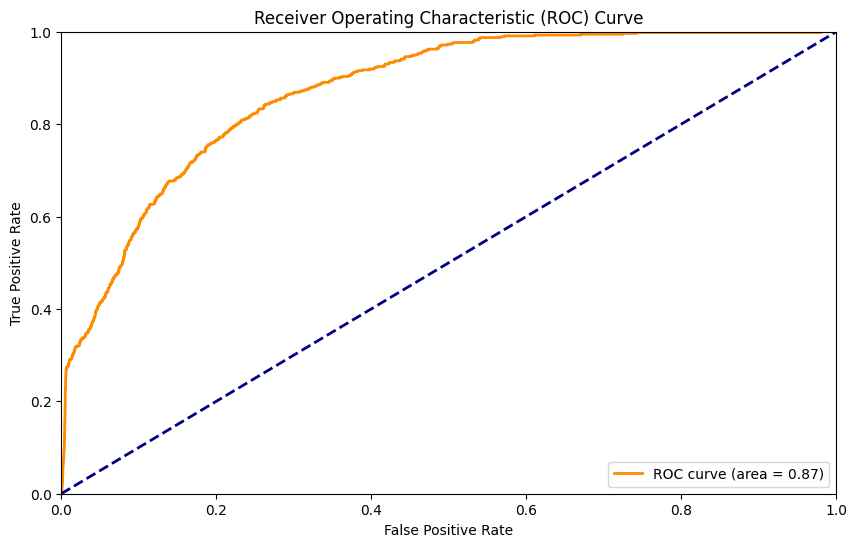

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Original Image Shape: (860, 538)Original Image Shape: (860, 538)

Original Image Shape: (860, 538)
Original Image Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)Preprocessed Image Shape: (128, 128, 3)

Original Mask Shape: (860, 538)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Preprocessed Image Shape: (128, 128, 3)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Original Mask Shape: (860, 538)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)
Preprocessed Mask Shape: (128, 128, 1)Preprocessed Mask Shape: (128, 128, 1)

Preprocessed Mask Shape: (128, 128, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


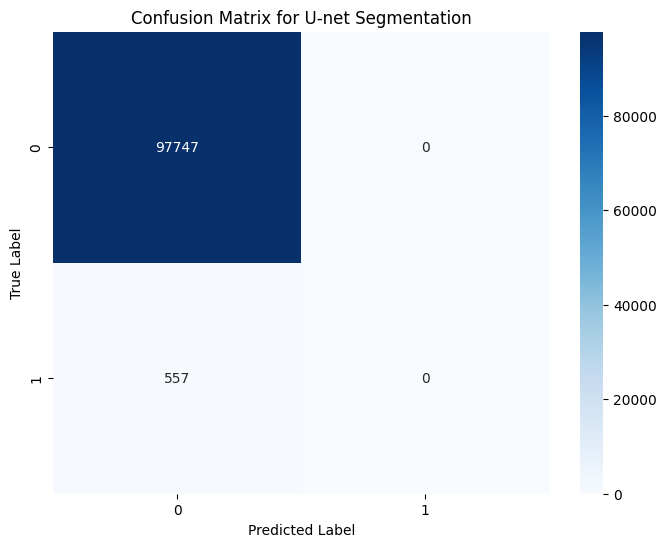

In [25]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your validation dataset as `val_dataset`

y_true = []
y_pred = []

# Iterate over the validation dataset
for images, masks in val_dataset:
    predictions = model.predict(images)

    # Apply threshold to get binary predictions
    predictions = (predictions > 0.5).astype(np.uint8)

    # Flatten the masks and predictions to 1D arrays
    y_true.append(masks.numpy().flatten())
    y_pred.append(predictions.flatten())

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for U-net Segmentation')
plt.show()
